In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# First order model regression - LS & MLE

# Select a noise-generating distribution
Probability density functions (PDFs):

Gaussian pdf: $P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Hyperparameters to adjust:
- dist: "laplace" or "gauss" : the class of noise-generating distribution.
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.

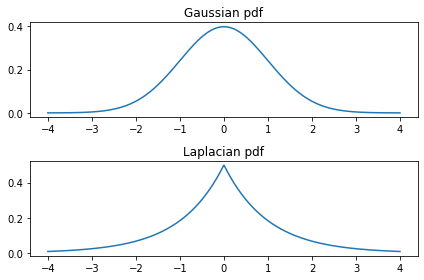

In [164]:
# Hyperparameters for the type of noise-generating distribution.
dist = "laplace"  # choose between "laplace" "or gauss"
loc = 0         # location (mean) parameter 
scale = 1       # scaling (std dev) parameter
magnitude = 1.2 # noise magnitude
N = 100         # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# The Gaussian probability density function:
# Also available in library "scipy.stats.norm"
def gauss_pdf(x, loc, scale):
    return 1.0/(scale * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - loc) / scale)**2 )

# Plot pdfs:
fig, [ax0, ax1] = plt.subplots(2)

n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf
ax0.plot(n, gauss_pdf(n, loc, scale))
ax0.set_title('Gaussian pdf')
ax1.plot(n,laplace_pdf(n, loc, scale))
ax1.set_title('Laplacian pdf')
plt.tight_layout()
plt.show()


## Least squares method
### Generating data
Here we will generate a synthetic dataset from a first order model **$y = \theta_1 \cdot u + \theta_0$** and add some Gaussian noise to simulate sampling of the data, giving us: **$y_{measured} = \theta_1 \cdot u + \theta_0 + err$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1}$ = model parameters   
$err$ = measurement noise

Given the input $u$ and the measured data **$y_{measured}$** we will try to estimate the first oreder model coeffitienst $\hat{\theta}_{0,1}$ using the Least sqaures method.



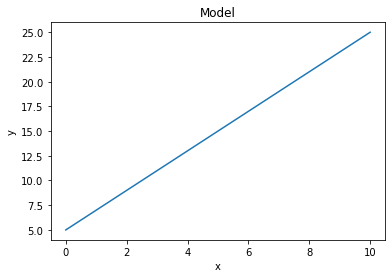

In [165]:
# Choose the "true" parameters for 1D polynomial model 
theta_0 = 5.0
theta_1 = 2.0
y_model = lambda x : theta_1 * x + theta_0

# Plot true model
x = np.linspace(start=0, stop=10, num=50)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

### Choose data generation parmeters:

In [166]:
#u = np.sort(np.random.normal(10,3,N))
u = np.sort(np.random.uniform(0,20,N))
y_true = y_model(u)

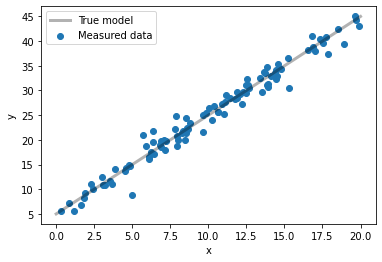

In [167]:
from scipy.stats import norm, laplace
if dist == "laplace":
    #pdf = laplace_pdf
    pdf = laplace.pdf
    noise = magnitude * np.random.laplace(loc, scale, N)
elif dist == "gauss":
    #pdf = gauss_pdf
    pdf = norm.pdf
    noise = magnitude * np.random.normal(loc, scale, N)
else:
    raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")

# Add noise to the model
y = y_true + noise

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(0, 20, 500)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

### Given the sampled data we can estimate the underlying model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (u^T\cdot u)^{-1}(u^T\cdot y)$

### Step 1 - rewrite the model in matrix form
$y_{measured} = \theta_1 \cdot u + \theta_0 + noise = [ \theta_0 \; \theta_1 ] \cdot [1 \; u]^T + noise$

In [168]:
# Matrix form
u_vec = np.reshape(u,(N,1))

print(f"u :\n{u_vec[0:5]} \n")
u_vec = np.append(np.ones((N,1)), u_vec,axis=1)
print(f"1, u :\n{u_vec[0:5,:]}")

u :
[[0.32258413]
 [0.87182928]
 [1.19355793]
 [1.66389977]
 [1.8420988 ]] 

1, u :
[[1.         0.32258413]
 [1.         0.87182928]
 [1.         1.19355793]
 [1.         1.66389977]
 [1.         1.8420988 ]]


### Step 2   

calculate $(u^T \cdot u)^{-1}$

In [169]:
u_transpose_dot_u = np.dot(u_vec.T,u_vec)  # calculating dot product
u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
print(u_transpose_dot_u_inv)

[[ 0.05175777 -0.00416388]
 [-0.00416388  0.0004152 ]]


### Step 3  

calculate $(u^T \cdot y)$

In [170]:
u_transpose_dot_y = np.dot(u_vec.T,y)  # calculating dot product
print(u_transpose_dot_y)

[ 2502.05436914 29832.44631554]


### Step 4 

solve for $\hat{\mathbf{\theta}} = (u^T\cdot u)^{-1}(u^T\cdot y)$

LS - (theta_0_hat, theta_1_hat): (5.282100569872242, 1.9682196126656049)
True model - (theta_0, theta_1): (5.0, 2.0)


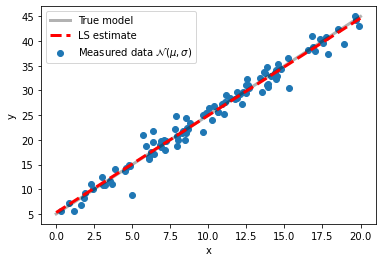

In [171]:
theta_hat = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
print(f"LS - (theta_0_hat, theta_1_hat): {theta_hat[0], theta_hat[1]}")
print(f"True model - (theta_0, theta_1): {theta_0, theta_1}")

# Recreate model based on LS estimate:
LS_estimate = lambda x : theta_hat[1] * x + theta_hat[0]

# Plot true vs. estimated model
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(0, 20, 500)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.plot(u0, LS_estimate(u0), "r--",  lw=3, label="LS estimate")
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

## The same regression problem can be solved using Maximum likelihood estimation - MLE
In the special case where the sampled data and the measurement noise are normally distributed
the MLE solution is equal to the LS solution, the code below solves the presented first order regression problem using maximum liklihood estimation.

Source: http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/3-4-UnivarMLE.html

### Step 1 - define the log likelihood function to be minimized

In [172]:
def log_lik(par_vec, y, x):
    global pdf  # Use the distribution class chosen earlier

    # If the standard deviation parameter is negative, return a large value:
    if par_vec[2] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
                loc = par_vec[0] + par_vec[1] * x,
                scale = par_vec[2])
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

### Step 2 - use optimization solver to fit the data to the likelihood function

In [173]:
import scipy.optimize as optimize

# Do Maximum Likelihood Estimation:
opt_res = optimize.minimize(fun = log_lik,
                            x0 = np.array([0, 0, N]),
                            args = (y, u))

print(f"MLE - [theta_0_hat, theta_1_hat, sigma_err_hat]: {opt_res.x[0], opt_res.x[1]}")
print(f"True model - [theta_0 theta_1 sigma_err]: {theta_0, theta_1, scale}")

MLE - [theta_0_hat, theta_1_hat, sigma_err_hat]: (5.029076212310434, 2.0088422764015603)
True model - [theta_0 theta_1 sigma_err]: (5.0, 2.0, 1)


## Comparing LS and MLE

In [174]:
print(f"LS - (theta_0_hat, theta_1_hat):  {theta_hat[0], theta_hat[1]}")
print(f"MLE - (theta_0_hat, theta_1_hat): {opt_res.x[0], opt_res.x[1]}")
print(f"True model parameters - (theta_0 theta_1):   {theta_0, theta_1}")

LS - (theta_0_hat, theta_1_hat):  (5.282100569872242, 1.9682196126656049)
MLE - (theta_0_hat, theta_1_hat): (5.029076212310434, 2.0088422764015603)
True model parameters - (theta_0 theta_1):   (5.0, 2.0)


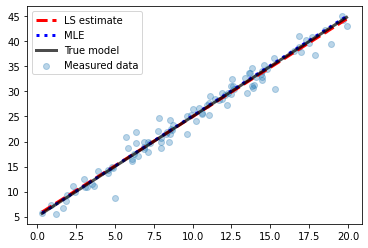

In [176]:
MLE_estimate = lambda x : opt_res.x[1] * x + opt_res.x[0]

plt.figure()
plt.scatter(u, y, alpha=0.3, label=r"Measured data")
plt.plot(u, LS_estimate(u), "r--",  lw=3, label="LS estimate")
plt.plot(u, MLE_estimate(u), "b:",  lw=3, label="MLE")
plt.plot(u, y_model(u), "k", alpha=0.7, lw=3, label="True model")
plt.legend();

### Calculating (Root mean square error) RMSE for LS and MLE

**RMSE** = $\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\big({\hat{y}_i - y_{i}}\big)^2}}$

In [177]:
print(f"LS - RMSE:  {np.sqrt(np.mean((LS_estimate(u)-y)**2))}")
print(f"MLE - RMSE: {np.sqrt(np.mean((MLE_estimate(u)-y)**2))}")

LS - RMSE:  1.6227842761607356
MLE - RMSE: 1.642254975964053
